# GWTC-3 mass-spin inference
#### Code: [gppop/spin-dev](https://github.com/AnaryaRay1/gppop/tree/spin-dev)

#### Contents 

- [Preamble](#Preamble), need to run.
- [Prepare Input for GWTC-3](#Prepare-input-for-GWTC-3)
- [Run Inference](#Run-inference)
- [GP sanity checks](#GP-sanity-checks)



## Preamble

In [1]:
import numpy as np
import pandas as pd
import h5py
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator,LogLocator,NullFormatter)
from matplotlib.colors import LogNorm
import glob
import yaml
from astropy.cosmology import Planck15,z_at_value
from astropy import units as u
from scipy.interpolate import interp1d

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
colors=sns.color_palette('colorblind')
fs=80

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [5]:
import pymc as pm

WARN: Could not locate executable armflang


/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: warning: libgfortran.so.5, needed by /usr/lib64/libopenblas.so, not found (try using -rpath or -rpath-link)
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `expf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `_gfortran_concat_string@GFORTRAN_8'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `powf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `logf@GLIBC_2.27'
/cvmfs/software.igwn.org/conda/envs/igwn-py39-20240305/compiler_compat/ld: /usr/lib64/libopenblas.so: undefined reference to `_gfortran_etime@GFORTRAN_8'
collect2: error: ld returned 1 exit status


In [6]:
import arviz as az

In [7]:
from gwdistributions.distributions.spin.effective import IsotropicUniformMagnitudeChiEffGivenComponentMass

/home/anarya.ray/gppop-prod/spindev/gw-distributions/gwdistributions/transforms/location.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal.lal import GreenwichMeanSiderealTime as GMST


In [8]:
from gppop.core import Utils_spins,Utils,Vt_Utils_spins, Rates_spins,Post_Proc_Utils_spins

In [9]:
mbins = np.array([  5. ,   6.5 ,  7.5 , 12.5 , 15. ,  17.5,  30.,   40.,   50.,   60.,  100. ])
chi_bins = np.array([-0.6,-0.4,-0.3,-0.2,-0.1,-0.05,0.,0.05,0.1,0.2,0.3,0.4,0.6])

In [10]:
utils = Utils_spins(mbins,chi_bins,kappa=2.7)

## Prepare input for GWTC-3
Needs data on CIT to run, can skip directly to [this cell](#Plot-results)

In [11]:
Zs = np.linspace(0.,10,1000)
DLs = Planck15.luminosity_distance(Zs).value
z_interp = interp1d(DLs,Zs)

In [ ]:
with open('gwtc-3.yaml', "r") as stream:
    config = yaml.full_load(stream)

In [ ]:
config.keys()

In [ ]:
spin_prior = IsotropicUniformMagnitudeChiEffGivenComponentMass()
spin_prior._init_values(max_spin_magnitude=0.99)

In [ ]:
N_samples = 4278
np.random.seed(2**31-78)
posterior_samples_o1o2 = np.zeros((len(config['event_dict'].keys()),N_samples,4))
spin_priors = [ ]
for i,filename in enumerate(config['event_dict'].values()):
    
    with h5py.File(filename[1],'r') as hf:
        posterior = hf[filename[0]][()]
        posterior = posterior[np.random.choice(len(posterior),size=N_samples,replace=False)]
        
        z = z_interp(posterior['luminosity_distance_Mpc'])
        m1 = posterior['m1_detector_frame_Msun']/(1+z)
        m2 = posterior['m2_detector_frame_Msun']/(1+z)
        chi_eff = (posterior['spin1']*posterior['costilt1']+(m2/m1)*posterior['spin2']*posterior['costilt2'])/(1.+m2/m1)
        posterior_samples_o1o2[i,:,:] = np.array([m1,m2,z,chi_eff]).T
        spin_priors.append(np.exp(spin_prior._logprob(chi_eff,m1,m2,0.99)))

posterior_samples_o3 = np.zeros((len(config['pe_summary_event_dict'].keys()),N_samples,4))
for i,filename in enumerate(config['pe_summary_event_dict'].values()):
    
    with h5py.File(filename[1],'r') as hf:
        posterior = hf[filename[0]]['posterior_samples'][()]
        posterior = posterior[np.random.choice(len(posterior),size=N_samples,replace=False)]
        z = posterior['redshift']
        m1 = posterior['mass_1_source']
        m2 = posterior['mass_2_source']
        chi_eff = posterior['chi_eff']
        posterior_samples_o3[i,:,:] = np.array([m1,m2,z,chi_eff]).T
        spin_priors.append(np.exp(spin_prior._logprob(chi_eff,m1,m2,0.99)))
        
posterior_samples_all = np.concatenate((posterior_samples_o1o2,posterior_samples_o3),axis=0)
spin_priors = np.array(spin_priors)

In [ ]:
posterior_samples_o2=[]
posterior_samples_o3=[]

In [ ]:
posterior_samples_all.shape


In [ ]:
spin_priors = np.array(spin_priors)
spin_priors[np.where(np.isnan(spin_priors))]=np.nanmin(spin_priors)

In [ ]:
weights = [ ]
for i,posterior_samples_this_event in enumerate(posterior_samples_all):
    weights.append(utils.arraynd_to_tril(utils.compute_weights(posterior_samples_this_event,chi_prior=spin_priors[i])))
    if i%10==0:
        print(i)

In [ ]:
weights = np.array(weights)

In [ ]:
weights.shape

In [ ]:
wts_sum = np.sum(weights,axis=0)

In [ ]:
print(len(wts_sum))

(10, 10, 12)


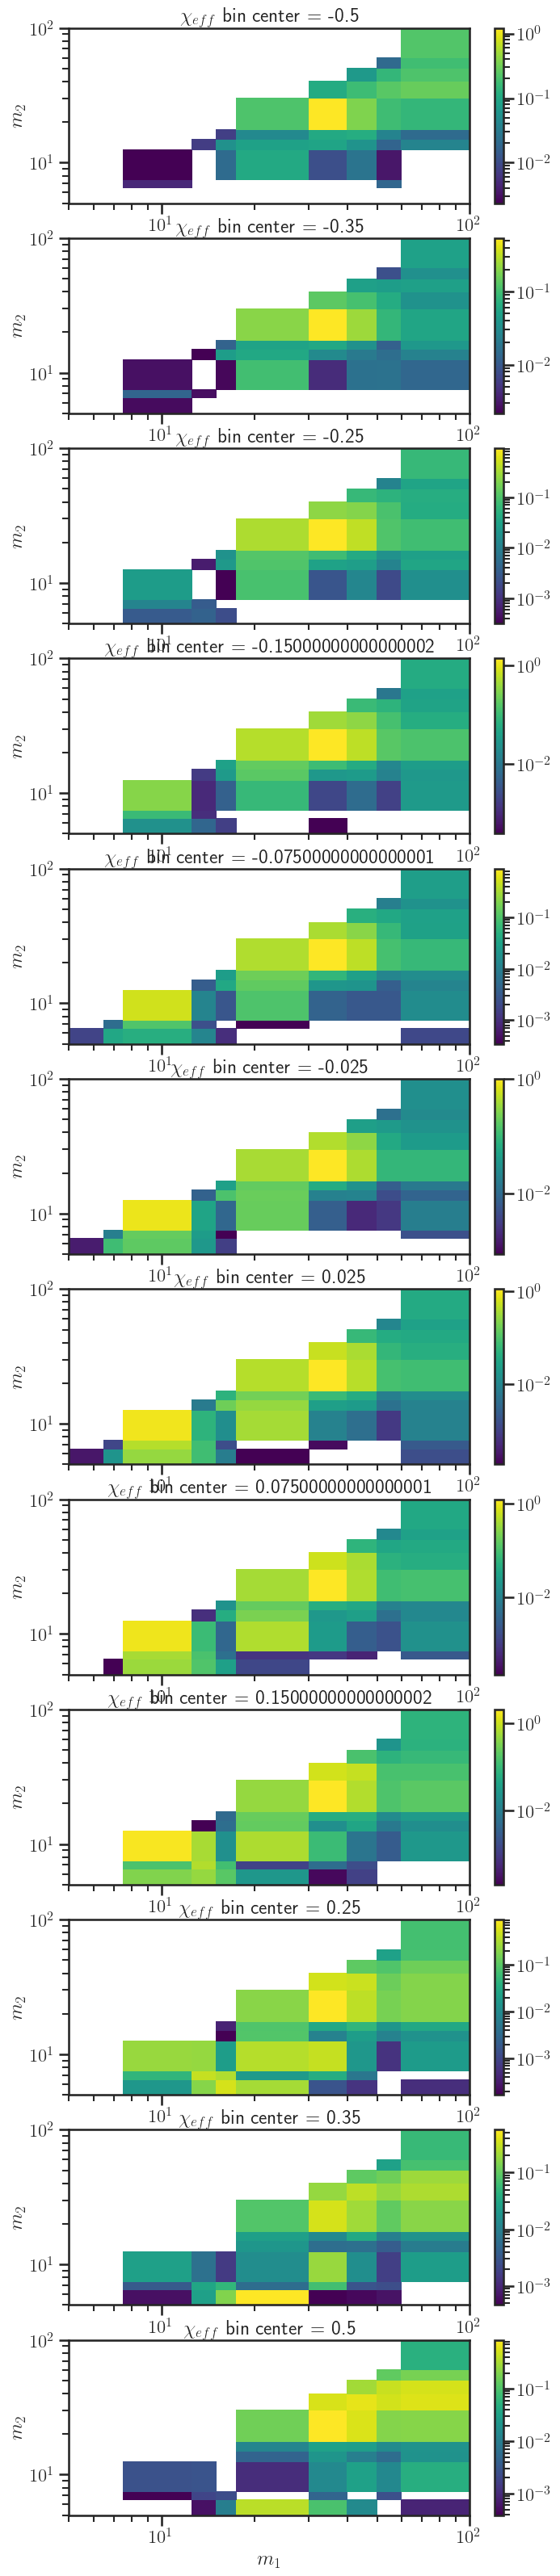

In [ ]:
fig,axes = plt.subplots(len(chi_bins)-1,figsize=(8,40))
wts_sum = np.sum(weights,axis=0)
w= utils.construct_1dtond_matrix(len(mbins)-1,wts_sum,nbins_chi=len(chi_bins)-1)
print(w.shape)
for i in range(len(chi_bins)-1):
        ax = axes[i]
        ax.set_title(r'$\chi_{eff}$ bin center = '+str(0.5*(chi_bins[i+1]+chi_bins[i])))
        matrix1 = w[:,:,i]
        if(matrix1.min()==matrix1.max()):
            continue

        pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=matrix1[matrix1!=0].min(),vmax=matrix1.max()),cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$m_1$')
        ax.set_ylabel(r'$m_2$')
        plt.colorbar(pc, ax = ax)
    #fig.colorbar()
plt.show()

In [ ]:
inj_dataset = {}
with h5py.File(config['injection_file'],'r') as hf:
    inj_dataset['analysis_time_s'] = hf.attrs['analysis_time_s'] # years
    inj_dataset['total_generated'] = hf.attrs['total_generated']
    for param,key in config['injection_keys'].items():
            inj_dataset[param] = hf[key][()]

chi_eff = (inj_dataset['mass1_source']*inj_dataset['spin1z']+
           inj_dataset['mass2_source']*inj_dataset['spin2z'])/(inj_dataset['mass1_source']+
                                                                        inj_dataset['mass2_source'])
inj_dataset['p_draw_chi_given_m1m2'] = np.exp(spin_prior._logprob(chi_eff,inj_dataset['mass1_source'],inj_dataset['mass2_source'],0.99))
thresh = config['threshold']
thresh_keys = config['threshold_keys']


In [ ]:
vt_utils = Vt_Utils_spins(mbins,chi_bins,kappa=2.7)

In [ ]:
vt_means,vt_sigmas = vt_utils.compute_VTs(inj_dataset,thresh,key = thresh_keys )

In [ ]:
vts_nd = utils.construct_1dtond_matrix(len(mbins)-1,vt_means,nbins_chi=len(chi_bins)-1)

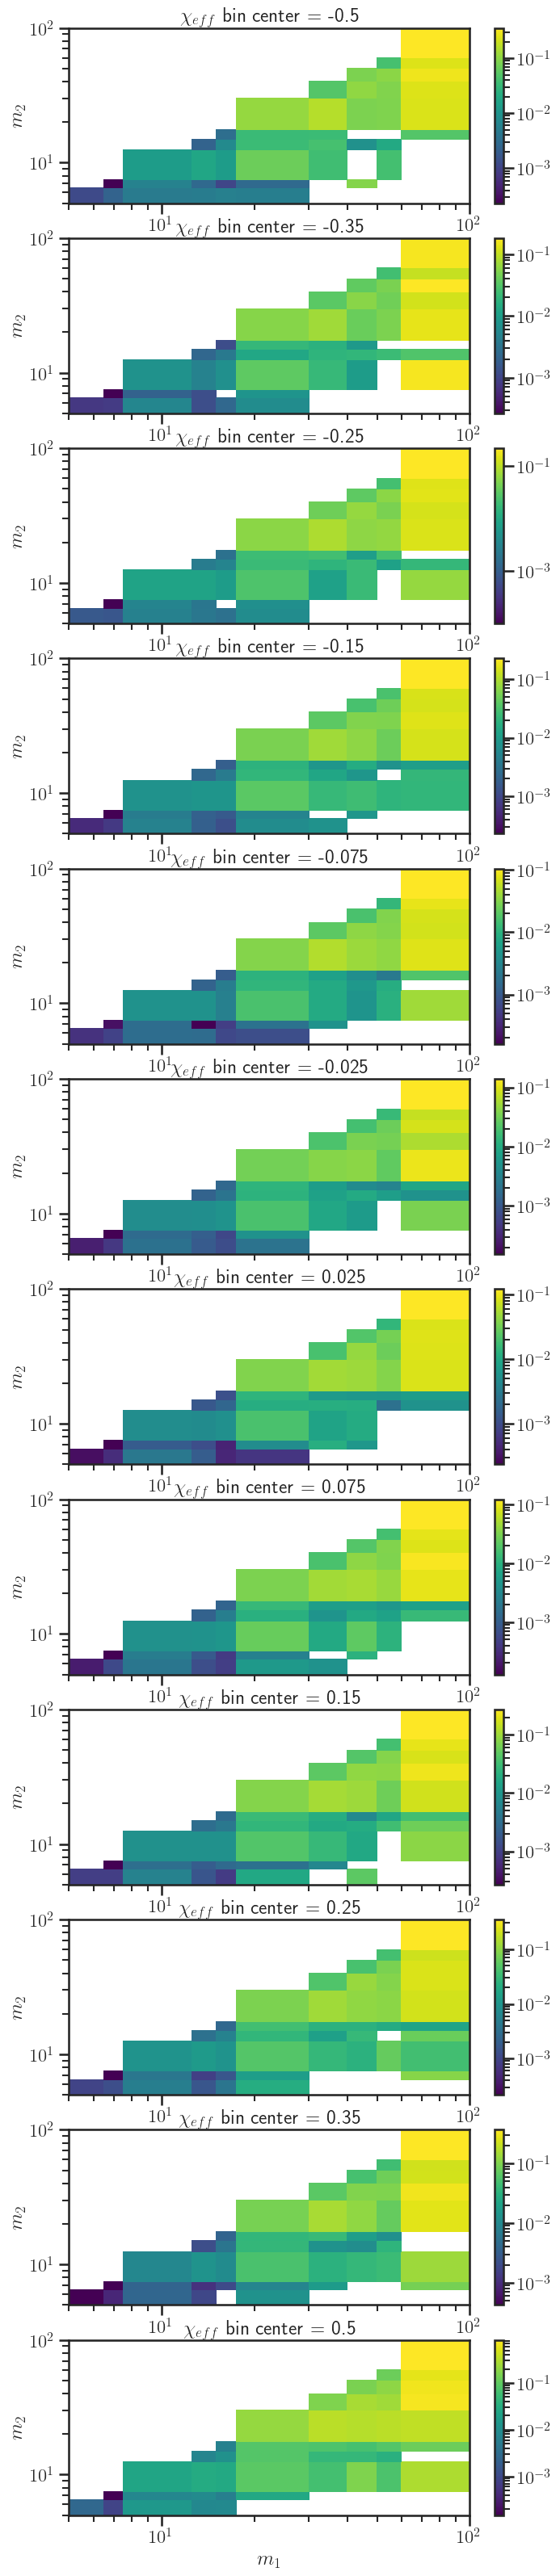

In [ ]:
fig,axes = plt.subplots(len(chi_bins)-1,figsize =(8,40))
for i in range(len(chi_bins)-1):
    ax = axes[i]
    ax.set_title(r'$\chi_{eff}$ bin center = '+str(int(1000*0.5*(chi_bins[i+1]+chi_bins[i]))/1000))
    matrix1 = vts_nd[:,:,i]
    
    pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=matrix1[matrix1!=0].min(),vmax=matrix1.max()),cmap='viridis')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$m_1$')
    ax.set_ylabel(r'$m_2$')
    plt.colorbar(pc, ax = ax)

plt.show()

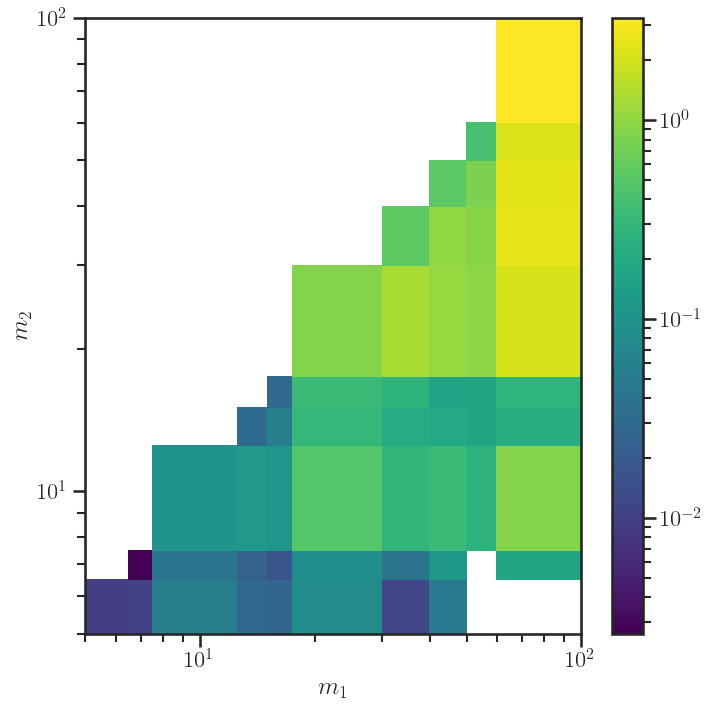

In [ ]:
fig,axes = plt.subplots(1,figsize =(8,8))
#for i in range(len(chi_bins)-1):
ax = axes
#ax.set_title(r'$\chi_{eff}$ bin center = '+str(int(1000*0.5*(chi_bins[i+1]+chi_bins[i]))/1000))
matrix1 = np.sum(vts_nd,axis=-1)

pc = ax.pcolor(mbins,mbins,matrix1.T,norm=LogNorm(vmin=matrix1[matrix1!=0].min(),vmax=matrix1.max()),cmap='viridis')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$m_1$')
ax.set_ylabel(r'$m_2$')
plt.colorbar(pc, ax = ax)

plt.show()

In [ ]:
arg = np.where(matrix1[np.tril_indices(len(matrix1))]==0)[0]
print(arg)


In [ ]:
nbins_m = len(mbins)-1
nbins_m = int(0.5*nbins_m*(nbins_m+1))
nbins_chi = len(chi_bins)-1
args = np.array([ ])
for i in range(nbins_chi-1):
    args = np.append(args,nbins_m*i+arg)
args=args.astype(int)


In [ ]:
log_bin_centers=utils.generate_log_bin_centers()
tril_deltaLogbin = utils.arraynd_to_tril(utils.deltaLogbin())

In [ ]:
def interpolate_vts(log_bin_centers,tril_deltaLogbin,tril_vts,arg=None):
        '''
        Function for interpolating VTs over bins that have no injections
        using a GP regressor.
        
        Parameters
        ----------
        
        tril_vts  :: numpy.ndarray
                     1d array containing VT meands or stds to be interpolated.
        
        arg       :: numpy.ndarray
                     1d array containing bin indices at which interpolated
                     VTs need to be calculated.
                     
        Returns
        -------
        
        new_vts  : numpy.ndarray
                   interpolated VTs.
        '''
        if(all(tril_vts>0) or arg is None):
            return tril_vts
        
        vts = tril_vts/tril_deltaLogbin
        X =log_bin_centers[vts!=0]
        y = np.log((vts)[vts!=0])
        kernel = RBF(length_scale=0.3,length_scale_bounds=[0.1,2])
        gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5).fit(X,y)
        y_pred = gp.predict(log_bin_centers[arg.astype(int)])
        vt_pred = np.exp(y_pred)
        new_vts = vts.copy()
        new_vts[arg.astype(int)] = vt_pred
        return new_vts*tril_deltaLogbin

In [ ]:
interp_vts = interpolate_vts(log_bin_centers,tril_deltaLogbin,vt_means,arg=args)

In [ ]:
np.savetxt('weights_GWTC3_IFAR1_m1m2chi_newbins3.txt',weights)

In [ ]:
np.savetxt('vts_GWTC3_IFAR1_m1m2chi_newbins3.txt',interp_vts/tril_deltaLogbin)

In [ ]:
np.savetxt('mbins.txt',mbins)
np.savetxt('chi_bins_new3.txt',chi_bins)

In [ ]:
dist_array = np.zeros(int(nbins_m*(nbins_m+1)/2))

chi_bin_centers = log_bin_centers[0::nbins_m,2]
logm_bin_centers = log_bin_centers[:nbins_m,:2]
k=0
for i in range(len(logm_bin_centers)):
    for j in range(i+1):
        dist_array[k] = np.linalg.norm(logm_bin_centers[i]-logm_bin_centers[j])
        k+=1

scale_min = np.log(np.min(dist_array[dist_array!=0.]))
scale_max = np.log(np.max(dist_array))
scale_mean_m = 0.5*(scale_min + scale_max) # chosen to give coverage over the bin-grid
scale_sd_m = (scale_max - scale_min)/4 # fix 3-sigma difference to the sd of the length scale dist

dist_array = np.zeros(int(nbins_chi*(nbins_chi+1)/2))
k=0
for i in range(len(chi_bin_centers)):
    for j in range(i+1):
        dist_array[k] = np.linalg.norm(chi_bin_centers[i]-chi_bin_centers[j])
        k+=1

scale_min = np.log(np.min(dist_array[dist_array!=0.]))
scale_max = np.log(np.max(dist_array))
scale_mean_chi = 0.5*(scale_min + scale_max) # chosen to give coverage over the bin-grid
scale_sd_chi = (scale_max - scale_min)/4 # fix 3-sigma difference to the sd of the length scale dist
print(scale_mean_m,scale_sd_m,scale_mean_chi,scale_sd_chi)

In [ ]:
np.savetxt('gp_inputs_newbins3.txt',np.array([scale_mean_m,scale_sd_m,scale_mean_chi,scale_sd_chi]))

## Run inference

## Sanity Checks

In [12]:
trace = az.from_netcdf('gppop_posterior_newbins3_kappa_corr.nc')

In [13]:
trace['posterior'].keys()

KeysView(<xarray.Dataset>
Dimensions:                   (chain: 4, draw: 2000, mu_dim_0: 1,
                               logn_corr_rotated__dim_0: 660,
                               logn_corr_dim_0: 660, logn_tot_dim_0: 660,
                               n_corr_dim_0: 660, n_corr_physical_dim_0: 585)
Coordinates:
  * chain                     (chain) int64 0 1 2 3
  * draw                      (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * mu_dim_0                  (mu_dim_0) int64 0
  * logn_corr_rotated__dim_0  (logn_corr_rotated__dim_0) int64 0 1 2 ... 658 659
  * logn_corr_dim_0           (logn_corr_dim_0) int64 0 1 2 3 ... 657 658 659
  * logn_tot_dim_0            (logn_tot_dim_0) int64 0 1 2 3 ... 656 657 658 659
  * n_corr_dim_0              (n_corr_dim_0) int64 0 1 2 3 4 ... 656 657 658 659
  * n_corr_physical_dim_0     (n_corr_physical_dim_0) int64 0 1 2 ... 583 584
Data variables:
    mu                        (chain, draw, mu_dim_0) float64 ...
    logn_corr_rotated_

In [14]:
N_samples = int(len(trace['posterior']['draw'])*len(trace['posterior']['chain']))

In [15]:
import gppop
gppop.__file__

'/home/anarya.ray/gppop-prod/spindev/gppop/src/gppop/__init__.py'

## GP sanity checks

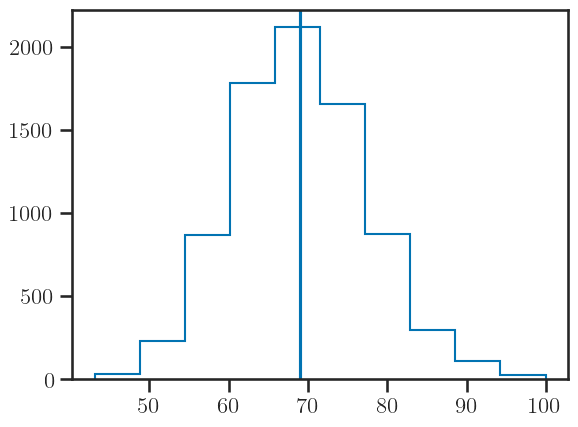

In [17]:
_=plt.hist(trace['posterior']['N_F_exp'].to_numpy().reshape((N_samples,)),histtype='step')
plt.axvline(69)#len(weights))

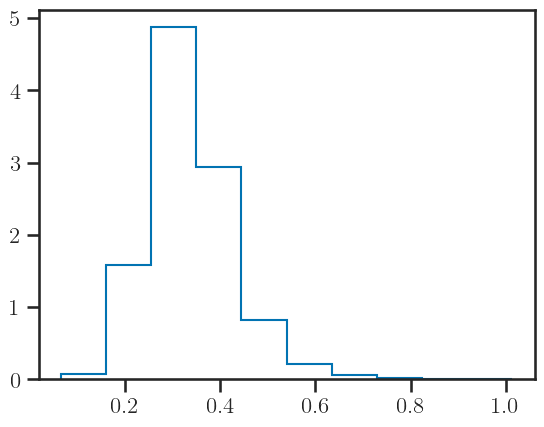

In [18]:
_=plt.hist(trace['posterior']['length_scale_m'].to_numpy().reshape((N_samples,)),histtype='step',density=True)

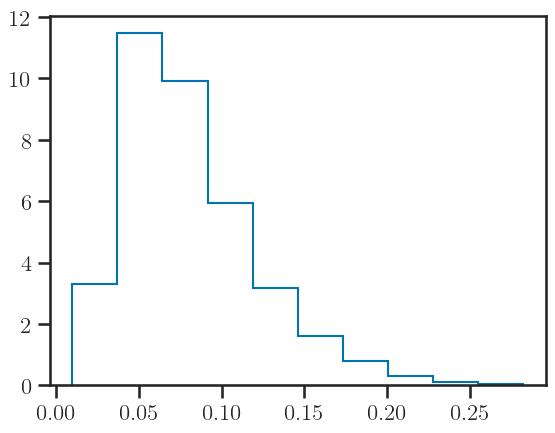

In [19]:
_=plt.hist(trace['posterior']['length_scale_chi'].to_numpy().reshape((N_samples,)),histtype='step',density=True)

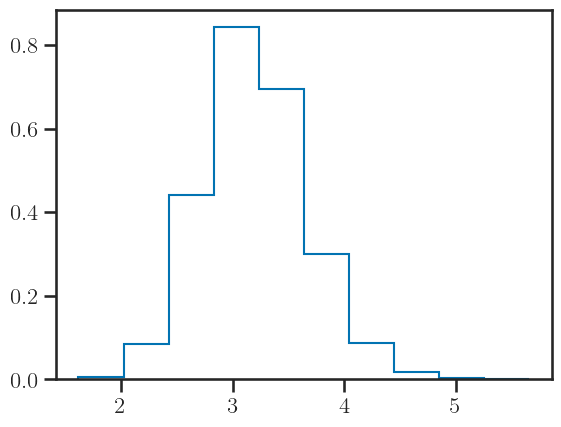

In [20]:
_=plt.hist(trace['posterior']['sigma'].to_numpy().reshape((N_samples,)),histtype='step',density=True)